In [1]:
%load_ext autoreload
%autoreload 2

from dataloader import SignalDataloader
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import lightning.pytorch as pl
import yaml
from tqdm import tqdm
from ml4gw.transforms import SpectralDensity, Whiten

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

/home/eric.moreno/gwak2/gwak/data/prior.py:5: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
data_dir = "/home/katya.govorkova/gwak2_background/"
sample_rate = 2048
kernel_length = 0.5
psd_length = 64
fduration = 1
fftlength = 2
batch_size = 512
batches_per_epoch = 10
num_workers = 2
data_saving_file = None
duration = fduration + kernel_length

from gwak.data.prior import SineGaussianBBC, LAL_BBHPrior, GaussianBBC, CuspBBC, KinkBBC, KinkkinkBBC, WhiteNoiseBurstBBC
from ml4gw.waveforms import SineGaussian, IMRPhenomPv2, Gaussian, GenerateString, WhiteNoiseBurst

signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "Background"
]
priors = [
    SineGaussianBBC(),
    LAL_BBHPrior(),
    GaussianBBC(),
    CuspBBC(),
    KinkBBC(),
    KinkkinkBBC(),
    WhiteNoiseBurstBBC(),
    None
]
waveforms = [
    SineGaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    IMRPhenomPv2(),
    Gaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    WhiteNoiseBurst(
        sample_rate=sample_rate,
        duration=duration
    ),
    None
]
extra_kwargs = [
    None,
    {"ringdown_duration":0.9},
    None,
    None,
    None,
    None,
    None,
    None
]

In [3]:
loader = SignalDataloader(signal_classes,
    priors,
    waveforms,
    extra_kwargs,
    data_dir=data_dir,
    sample_rate=sample_rate,
    kernel_length=kernel_length,
    psd_length=psd_length,
    fduration=fduration,
    fftlength=fftlength,
    batch_size=batch_size,
    batches_per_epoch=batches_per_epoch,
    num_workers=num_workers,
    data_saving_file=data_saving_file
)
test_loader = loader.test_dataloader()

['background-1241002600-3101.hdf5.lock', 'background-1240624412-20000.hdf5', 'background-1240594562-12186.hdf5', 'background-1240750849-12554.hdf5', 'background-1241393338-4562.hdf5', 'background-1240644412-9960.hdf5.lock', 'background-1240849944-3641.hdf5', 'background-1241302060-7884.hdf5.lock', 'background-1241088652-3696.hdf5', 'background-1240872261-20000.hdf5.lock', 'background-1240960621-590.hdf5.lock', 'background-1240853610-680.hdf5', 'background-1241068861-4928.hdf5', 'background-1240784297-1811.hdf5', 'background-1240892261-14732.hdf5', 'background-1241402964-6540.hdf5.lock', 'background-1241310397-20000.hdf5', 'background-1240594562-12186.hdf5.lock', 'background-1241001309-1186.hdf5.lock', 'background-1241417182-20000.hdf5', 'background-1241437182-6601.hdf5', 'background-1240914063-5293.hdf5.lock', 'background-1241393338-4562.hdf5.lock', 'background-1240658942-9110.hdf5', 'background-1240821139-11339.hdf5', 'background-1240981309-20000.hdf5', 'background-1241123878-20000.hd

In [4]:
for batch in test_loader:
    [batch] = batch
    print(batch)
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    x = loader.multiInject(waveforms, batch)
    labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)])
    break

tensor([[[-2.5060e-21, -1.4500e-20, -7.6589e-21,  ..., -5.8987e-20,
          -6.1722e-20, -6.1003e-20],
         [ 7.4094e-21,  7.4997e-20,  6.5729e-22,  ...,  1.2280e-19,
           3.9919e-20,  8.4130e-20]],

        [[ 2.3937e-20,  2.5139e-20,  3.2679e-20,  ..., -7.1361e-20,
          -7.5614e-20, -7.6287e-20],
         [ 2.0971e-19,  1.1998e-19,  1.3858e-19,  ...,  2.7394e-19,
           3.5359e-19,  3.6479e-19]],

        [[-1.1697e-19, -1.1845e-19, -1.2029e-19,  ...,  4.6513e-20,
           5.1778e-20,  4.6412e-20],
         [ 9.7305e-20,  6.9545e-20,  1.1207e-19,  ..., -1.5977e-19,
          -1.0728e-19, -1.1883e-19]],

        ...,

        [[ 7.3936e-20,  8.1671e-20,  7.6050e-20,  ..., -9.5224e-20,
          -9.0792e-20, -8.8483e-20],
         [-3.6500e-19, -4.1815e-19, -3.4393e-19,  ...,  3.9167e-20,
           1.0924e-19,  8.1297e-20]],

        [[ 1.2041e-19,  1.3521e-19,  1.3047e-19,  ...,  2.3985e-20,
           2.3357e-20,  1.9345e-20],
         [-6.1930e-21, -6.4776e-2

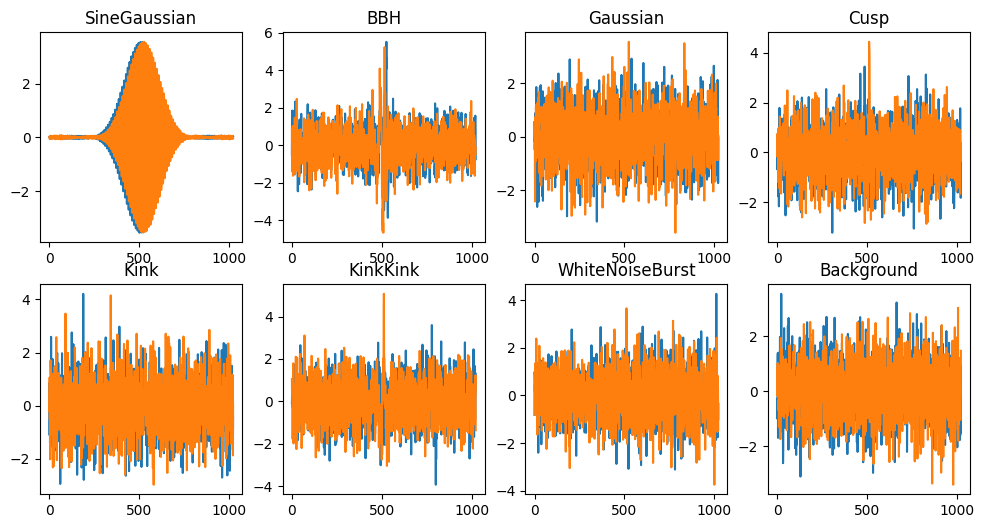

In [5]:
fig,axes = plt.subplots(2,4,figsize=(12,6))

for i, c in enumerate(signal_classes):
    plt.sca(axes[i//4,i%4])
    for k in range(1,2):
        xsel = x[labels==i+1][k,0,:]
        n = np.arange(len(xsel))
        plt.plot(n,xsel.cpu().numpy())
        xsel = x[labels==i+1][k,1,:]
        plt.plot(n,xsel.cpu().numpy())
    plt.title(c)

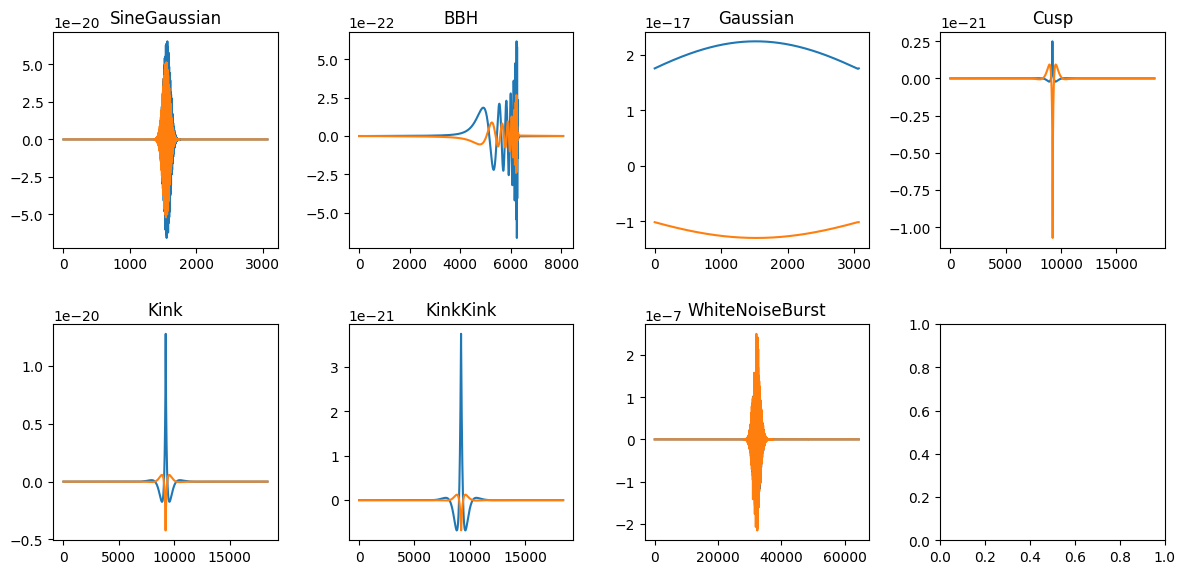

In [6]:
fig,axes = plt.subplots(2,4,figsize=(12,6))

for i, c in enumerate(signal_classes):
    plt.sca(axes[i//4,i%4])
    if waveforms[i] is None:
        continue
    xsel = waveforms[i][0,0,:]
    n = np.arange(len(xsel))
    plt.plot(n,xsel.cpu().numpy())
    xsel = waveforms[i][0,1,:]
    plt.plot(n,xsel.cpu().numpy())
    plt.title(c)
plt.tight_layout()

In [7]:
def plot(i,hp=None):

    b = batch[:1].clone()
    w = waveforms[i][:1].clone()

    split_size = int((kernel_length + fduration) * sample_rate)
    splits = [b.size(-1) - split_size, split_size]
    psd_data, bt = torch.split(b.clone(), splits, dim=-1)

    spectral_density = SpectralDensity(
        sample_rate,
        fftlength,
        average = 'median'
    )
    spectral_density = spectral_density.to('cuda') if torch.cuda.is_available() else spectral_density

    psds = spectral_density(psd_data.double())

    inj_len = w.shape[-1]
    window_len = splits[1]
    half = int((window_len - inj_len)/2)

    first_half, second_half = half, window_len - half - inj_len
    wf = F.pad(
        input=w,
        pad=(first_half, second_half),
        mode='constant',
        value=0
    )

    summed = bt + wf

    whitener = Whiten(
                fduration,
                sample_rate,
                highpass = hp,
            )
    whitener = whitener.to('cuda') if torch.cuda.is_available() else whitener

    whitened = whitener(summed.double(), psds.double())

    # normalize the input data
    stds = torch.std(whitened, dim=-1, keepdim=True)
    whitened = whitened / stds


    fig,axes = plt.subplots(1,4,figsize=(20,4))
    n = np.arange(wf.shape[-1])

    plt.sca(axes[0])
    plt.plot(n,wf[0,0,:].cpu().numpy())
    plt.plot(n,wf[0,1,:].cpu().numpy())
    plt.title('waveform')

    plt.sca(axes[1])
    plt.plot(n,bt[0,0,:].cpu().numpy())
    plt.plot(n,bt[0,1,:].cpu().numpy())
    plt.title('bkg')


    plt.sca(axes[2])
    plt.plot(n,summed[0,0,:].cpu().numpy())
    plt.plot(n,summed[0,1,:].cpu().numpy())
    plt.title('sum')

    plt.sca(axes[3])
    n2 = np.arange(whitened.size(-1))
    plt.plot(n2,whitened[0,0,:].cpu().numpy())
    plt.plot(n2,whitened[0,1,:].cpu().numpy())
    plt.title('whitened')

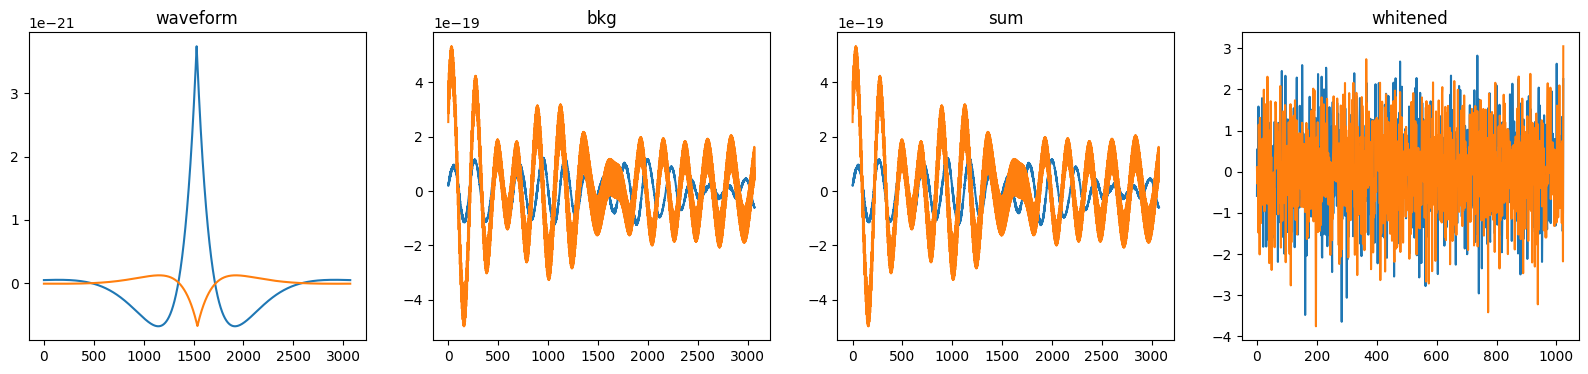

In [8]:
plot(5,hp=30)

In [9]:
from models import Crayon
import yaml

ckpt = "../output/test_S4_fixedSignals_0p5sec_v2/lightning_logs/2wla29uz/checkpoints/33-1700.ckpt"
cfg_path = "../output/test_S4_fixedSignals_0p5sec_v2/config.yaml"
with open(cfg_path,"r") as fin:
    cfg = yaml.load(fin,yaml.FullLoader)

model = Crayon.load_from_checkpoint(ckpt,**cfg['model']['init_args'])
model = model.eval()

In [17]:
tot = 0
output = []
labs = []
for batch in tqdm(test_loader):
    [batch] = batch
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    x = loader.multiInject(waveforms, batch)
    labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)])
    
    with torch.no_grad():
        y = model.model(x).cpu().numpy()
    
    output.append(y)
    labs.append(labels.cpu().numpy())
    
    tot += y.shape[0]

l = np.concatenate(labs)
y = np.concatenate(output,axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:04<?, ?it/s]


AttributeError: 'SignalDataloader' object has no attribute 'prior'

In [11]:
with torch.no_grad():
    y1 = model.model(x).cpu().numpy()
    y2 = model.model(x).cpu().numpy()

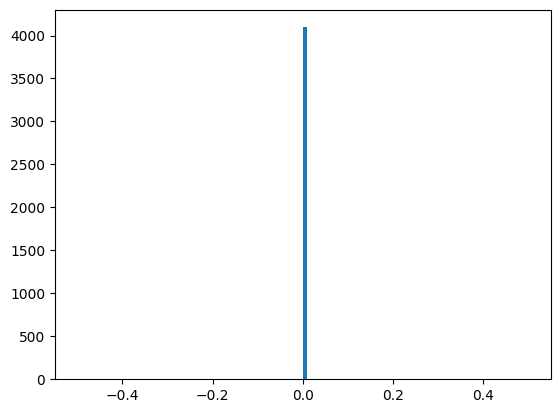

In [12]:
h=plt.hist((y1-y2).flatten(),bins=100)

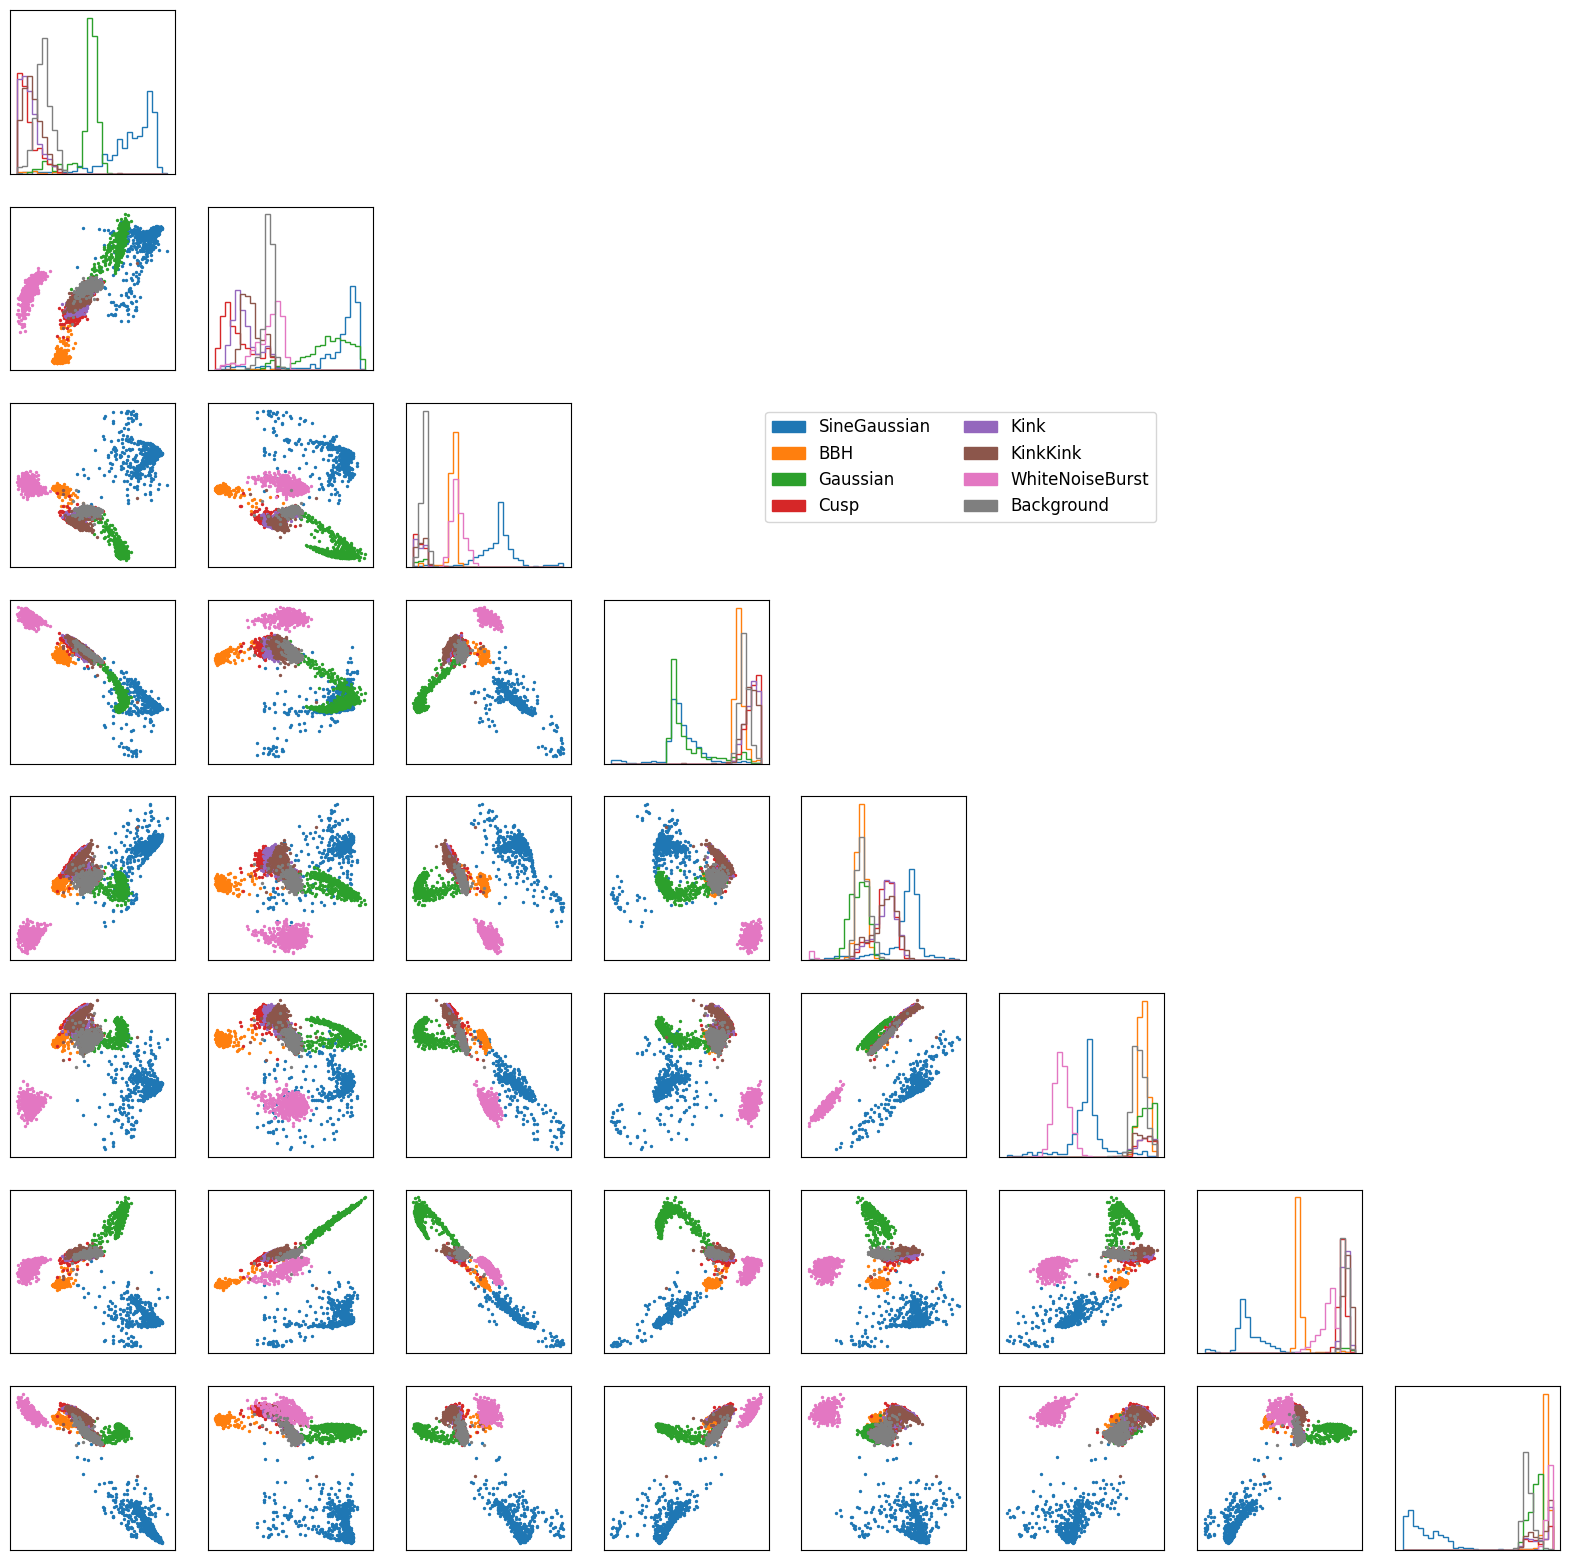

In [13]:
#import corner

N = y.shape[1]
labs_uniq = sorted(list(set(l)))
fig,axes = plt.subplots(N,N,figsize=(20,20))

for i in range(y.shape[1]):
    for j in range(i+1,y.shape[1]):
        plt.sca(axes[i,j])
        plt.axis('off')

for i in range(y.shape[1]):
    plt.sca(axes[i,i])
    plt.xticks([])
    plt.yticks([])
    bins = 30
    for j,lab in enumerate(labs_uniq):
        h,bins,_ = plt.hist(y[l==lab][:,i],bins=bins,histtype='step',color=f"C{j}")
        
for i in range(1,y.shape[1]):
    for j in range(i):
        plt.sca(axes[i,j])
        plt.xticks([])
        plt.yticks([])
        for k,lab in enumerate(labs_uniq):
            ysel = y[l==lab]
            plt.scatter(ysel[:,j],ysel[:,i],s=2,color=f"C{k}")
            
from matplotlib.patches import Patch
plt.sca(axes[2,5])
patches = []
for k,lab in enumerate(labs_uniq):
    patches.append(Patch(color=f"C{k}",label=signal_classes[k]))
plt.legend(handles=patches,ncol=2,fontsize=12)

#plt.tight_layout()

plt.savefig("test.png")
#for i,lab in enumerate(sorted(list(set(l)))):
#    corner.corner(y[l==lab],fig=fig,color=f"C{i}")

In [21]:
combined_model_path = "/home/eric.moreno/gwak2/gwak/output/combination/model_JIT.pt" # Replace with your actual model file path
combined_model = torch.jit.load(combined_model_path)
combined_model = combined_model.to(device)
combined_model.eval()

# Containers to store anomaly scores and binary labels
all_scores = []
all_binary_labels = []

# Iterate over the test data loader
for batch in tqdm(test_loader):
    [batch] = batch
    # Generate the corresponding waveforms
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    
    # Process the waveforms into the required input format
    x = loader.multiInject(waveforms, batch)
    
    # Reconstruct the ground truth multi-class labels
    labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)]).to(device)
    
    with torch.no_grad():
        # The combined model directly outputs the anomaly score
        scores = combined_model(x).squeeze()  # (batch_size,)
        scores = scores.cpu().numpy()
        # Invert the scores so that higher values correspond to more anomalous behavior
        scores = -scores
    
    # Convert the multi-class labels to binary labels:
    # Treat "Background" (assumed to be label 8) as 0 (normal) and all other classes as 1 (anomaly)
    binary_labels = (labels != 8).cpu().numpy()
    
    all_scores.append(scores)
    all_binary_labels.append(binary_labels)

# Concatenate scores and labels across batches
all_scores = np.concatenate(all_scores)
all_binary_labels = np.concatenate(all_binary_labels)

# Compute the ROC curve and AUC using scikit-learn
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(all_binary_labels, all_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [12:45<00:00, 76.57s/it]


ModuleNotFoundError: No module named 'sklearn'

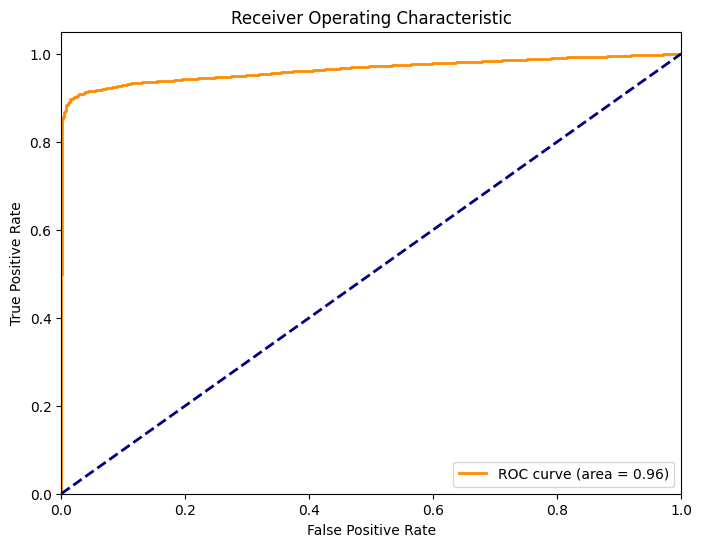

In [22]:
# Compute the ROC curve and AUC using scikit-learn
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(all_binary_labels, all_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [31]:
# Load the combined anomaly detection model (update the path accordingly)
combined_model = torch.jit.load(combined_model_path)
combined_model = combined_model.to(device)  # ensure model is on the same device
combined_model.eval()

# Containers to store anomaly scores and multi-class labels (as numeric values)
all_scores = []
all_labels = []

# Iterate over the test data loader
for batch in tqdm(test_loader):
    [batch] = batch
    # Generate the corresponding waveforms
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    print(params)
    batch = batch.to(device)
    
    # Process the waveforms into the required input format
    x = loader.multiInject(waveforms, batch)
    
    # Construct the ground truth multi-class labels.
    # Here each class gets a label from 1 to num_classes; "Background" is assumed to be the last class (label = 8).
    labels = torch.cat([(i+1) * torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)]).to(device)
    
    with torch.no_grad():
        # The combined model directly outputs the anomaly score for each input.
        scores = combined_model(x).squeeze()  # shape: (batch_size,)
        scores = scores.cpu().numpy()
        # Invert the scores so that higher values correspond to more anomalous behavior.
        scores = -scores
    
    all_scores.append(scores)
    all_labels.append(labels.cpu().numpy())

# Concatenate results across batches
all_scores = np.concatenate(all_scores)
all_labels = np.concatenate(all_labels)

# The list of signal class names, with the last one being "Background".
signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "Background"
]

# Compute and plot ROC curves for each anomaly class (all but "Background").
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for each anomaly class

for i, anomaly_class in enumerate(signal_classes[:-1]):  # Exclude "Background"
    # The anomaly class numeric label is i+1.
    anomaly_val = i + 1
    # Filter to only examples that are either the current anomaly class or Background (label 8).
    idx = np.where((all_labels == anomaly_val) | (all_labels == 8))[0]
    if idx.size == 0:
        continue  # skip if no examples
    scores_i = all_scores[idx]
    # Create binary ground truth: positive if the example is of the current anomaly class, 0 if background.
    binary_labels = (all_labels[idx] == anomaly_val).astype(int)
    
    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(binary_labels, scores_i)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f"{anomaly_class} (AUC = {roc_auc:.2f})")

# Plot reference line (diagonal)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.ylog()
plt.title("ROC Curves by Anomaly Class")
plt.legend(loc="lower right")
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

[OrderedDict([('hrss', tensor([4.8588e-20, 4.8528e-20, 4.4366e-20, 4.6795e-20, 3.5017e-20, 3.7675e-20,
        3.7948e-20, 3.4738e-20, 1.3720e-20, 1.6424e-21, 3.1807e-20, 4.8424e-20,
        4.4327e-20, 2.9030e-20, 8.6569e-21, 3.5456e-20, 1.9958e-20, 1.2860e-20,
        6.8737e-21, 4.1961e-20, 5.8217e-21, 4.2438e-21, 1.8847e-20, 4.1078e-20,
        4.7133e-20, 2.8101e-20, 2.4867e-20, 7.9836e-21, 4.4576e-20, 2.1396e-20,
        2.6341e-20, 6.7060e-21, 2.2076e-20, 3.7173e-20, 3.6014e-20, 3.3820e-20,
        1.9875e-20, 2.6270e-21, 2.5396e-20, 2.0776e-20, 2.6025e-20, 6.3028e-22,
        2.7767e-20, 1.0658e-20, 1.9827e-20, 2.2912e-20, 1.4122e-20, 7.3383e-21,
        1.0537e-20, 3.0129e-20, 2.6588e-20, 1.3612e-20, 1.9678e-20, 1.2715e-20,
        3.7160e-20, 8.0421e-21, 2.7095e-20, 1.2988e-20, 2.3031e-20, 2.7395e-20,
        4.7621e-20, 4.1314e-20, 4.9650e-21, 4.7793e-20])), ('quality', tensor([683.0699, 155.9106, 491.5178, 201.1152,  15.0513, 234.3858, 153.8768,
        423.7831, 618.8378, 

 10%|█         | 1/10 [01:26<12:55, 86.14s/it]

[OrderedDict([('hrss', tensor([1.9881e-20, 9.7917e-21, 5.5509e-21, 4.4782e-20, 4.1338e-20, 2.4591e-20,
        2.5141e-20, 1.7190e-20, 4.0791e-20, 1.4950e-20, 2.8448e-20, 1.0841e-21,
        2.2411e-20, 1.6597e-20, 4.7453e-20, 4.8494e-20, 4.7791e-20, 2.0339e-20,
        2.4017e-20, 1.1226e-20, 5.8659e-21, 9.9738e-21, 3.5232e-20, 2.4098e-20,
        7.7276e-21, 1.3991e-20, 1.9301e-20, 2.3182e-20, 2.7098e-20, 8.7538e-21,
        2.0566e-20, 4.0169e-20, 1.0350e-20, 1.6470e-20, 4.6660e-20, 9.1499e-21,
        1.2276e-20, 4.7153e-20, 2.3983e-20, 1.2905e-20, 1.9961e-20, 9.2532e-21,
        2.8049e-20, 1.9301e-20, 3.2491e-21, 1.1537e-21, 2.6336e-20, 4.5732e-20,
        1.1343e-20, 4.9256e-20, 4.2529e-20, 7.7291e-21, 1.9550e-20, 3.7568e-20,
        1.7005e-20, 1.7164e-20, 1.5381e-20, 2.1825e-20, 1.3798e-20, 3.0703e-20,
        2.9419e-20, 1.1767e-20, 4.7188e-20, 1.9170e-22])), ('quality', tensor([222.2977, 660.5171, 487.1559, 614.1732, 642.8827, 276.2396, 524.1118,
        531.8049, 202.8012, 

 20%|██        | 2/10 [02:47<11:08, 83.53s/it]

[OrderedDict([('hrss', tensor([4.9631e-20, 1.1758e-22, 1.0881e-20, 1.6315e-20, 3.7161e-20, 4.5195e-20,
        2.3909e-20, 2.9037e-20, 2.3203e-21, 4.0517e-20, 4.3597e-20, 8.9141e-21,
        2.5841e-20, 2.8628e-20, 9.9293e-21, 3.9620e-20, 2.9706e-20, 3.6277e-20,
        2.6837e-20, 3.6006e-20, 3.7323e-20, 1.5269e-20, 1.7602e-20, 4.7356e-20,
        3.0927e-21, 4.8189e-20, 3.7041e-20, 2.0590e-20, 2.8365e-20, 9.0345e-21,
        9.7357e-21, 1.0980e-20, 1.6938e-20, 5.7717e-21, 8.1411e-21, 2.3187e-20,
        4.9611e-20, 4.0083e-20, 2.3776e-20, 1.4511e-20, 2.3870e-20, 3.1366e-20,
        7.6758e-21, 1.9903e-20, 1.8032e-20, 1.8232e-20, 2.9312e-20, 2.4214e-20,
        2.0453e-20, 5.1630e-21, 3.8056e-20, 4.1760e-20, 2.5264e-20, 2.3350e-20,
        2.3259e-20, 9.5807e-21, 2.4198e-20, 1.0334e-20, 3.7525e-20, 2.7046e-20,
        7.3156e-21, 3.3653e-20, 5.4726e-21, 2.0118e-20])), ('quality', tensor([426.4283, 426.1232, 119.7406, 424.4496, 459.0501, 130.6738, 661.6929,
        517.4988, 360.6014, 

 30%|███       | 3/10 [04:11<09:44, 83.47s/it]

[OrderedDict([('hrss', tensor([4.7308e-20, 3.3329e-20, 3.3765e-20, 3.3340e-20, 3.8104e-20, 1.5639e-20,
        4.7718e-20, 3.2153e-21, 3.1275e-20, 3.7913e-20, 3.3208e-20, 4.8266e-20,
        4.2600e-20, 2.2710e-20, 8.2124e-21, 4.2842e-20, 2.7269e-20, 6.2286e-21,
        3.9135e-20, 6.0585e-21, 2.5008e-20, 1.9704e-20, 2.2092e-20, 1.5308e-20,
        2.0417e-20, 4.6277e-20, 3.3003e-20, 3.7029e-20, 4.6214e-20, 3.9600e-20,
        3.3691e-20, 2.1348e-21, 1.9547e-20, 7.5676e-21, 1.5022e-20, 4.9551e-20,
        4.5445e-20, 3.2349e-20, 4.1768e-20, 1.6201e-20, 4.5397e-20, 3.4717e-20,
        2.5067e-20, 2.9916e-20, 3.6593e-20, 2.1522e-20, 4.2419e-20, 4.2069e-20,
        2.2322e-21, 3.0257e-20, 1.5985e-20, 4.2989e-20, 2.7945e-20, 4.6872e-20,
        1.4136e-20, 3.7143e-20, 4.4327e-20, 2.7076e-21, 3.8008e-20, 1.7993e-20,
        4.0705e-20, 3.0303e-20, 2.7731e-20, 1.5380e-20])), ('quality', tensor([151.7566, 575.4084, 117.2544, 245.6745, 633.6812, 647.0596, 262.4460,
        348.8610, 408.5828, 

 40%|████      | 4/10 [05:31<08:13, 82.26s/it]

[OrderedDict([('hrss', tensor([1.9498e-20, 1.4175e-20, 2.9329e-20, 1.3765e-20, 6.1729e-21, 5.7125e-21,
        1.1356e-21, 8.3593e-21, 5.7348e-21, 4.5187e-20, 1.5734e-20, 1.0214e-20,
        1.2758e-21, 4.6194e-20, 8.3533e-21, 1.3869e-20, 3.3386e-20, 3.8554e-20,
        2.8140e-20, 1.0572e-21, 2.4551e-20, 2.4102e-20, 4.0908e-20, 2.8656e-20,
        2.6093e-20, 6.8749e-21, 1.3130e-20, 5.3220e-21, 2.6835e-20, 3.8072e-20,
        2.8992e-20, 2.6861e-20, 2.5735e-20, 1.4100e-20, 4.1433e-20, 2.7015e-21,
        1.9840e-21, 6.1381e-21, 1.5239e-20, 3.5638e-20, 3.7117e-20, 2.9401e-20,
        1.8747e-20, 7.1316e-21, 9.9174e-21, 1.6041e-20, 4.2934e-20, 1.8581e-20,
        3.6638e-20, 9.1426e-21, 5.9272e-21, 4.3835e-20, 3.3470e-20, 1.4574e-20,
        2.7127e-20, 2.7682e-20, 3.3694e-20, 1.6850e-20, 1.3222e-20, 3.6055e-20,
        4.9553e-20, 1.8225e-20, 1.2032e-21, 3.3740e-20])), ('quality', tensor([122.6199, 413.9544, 340.1324, 506.2599, 610.8720,  73.4884, 327.7502,
        414.7657, 245.7331, 

 50%|█████     | 5/10 [07:53<07:53, 94.65s/it]


KeyboardInterrupt: 

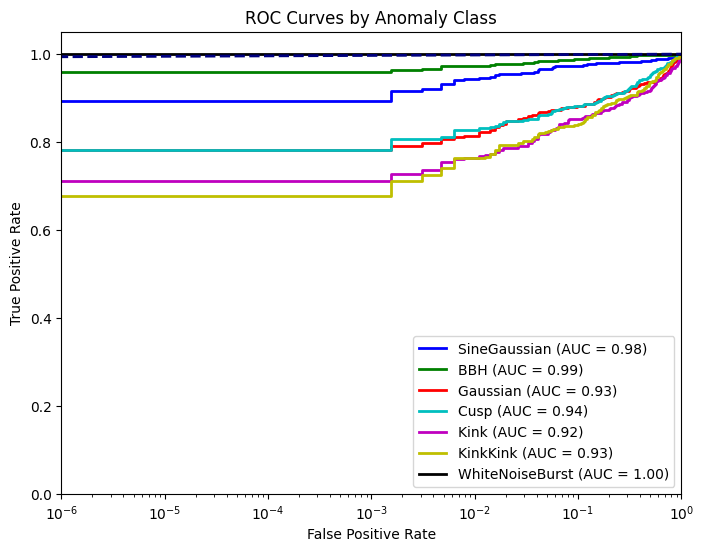

In [30]:
plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for each anomaly class

for i, anomaly_class in enumerate(signal_classes[:-1]):  # Exclude "Background"
    # The anomaly class numeric label is i+1.
    anomaly_val = i + 1
    # Filter to only examples that are either the current anomaly class or Background (label 8).
    idx = np.where((all_labels == anomaly_val) | (all_labels == 8))[0]
    if idx.size == 0:
        continue  # skip if no examples
    scores_i = all_scores[idx]
    # Create binary ground truth: positive if the example is of the current anomaly class, 0 if background.
    binary_labels = (all_labels[idx] == anomaly_val).astype(int)
    
    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(binary_labels, scores_i)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f"{anomaly_class} (AUC = {roc_auc:.2f})")

# Plot reference line (diagonal)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([1e-6, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#make x axis log
plt.xscale('log')

plt.title("ROC Curves by Anomaly Class")
plt.legend(loc="lower right")
plt.show()